In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model

## Data Preprocessing

In [ ]:
df = pd.read_csv('ml1m_ratings.csv',sep=',', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#+1 is the real size, as they are zero based
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [ ]:
df = df.dropna()

In [ ]:
train_df, test_df, y_train, y_test = train_test_split(df,df['user_emb_id'],test_size=0.1,random_state=18133047)  

In [ ]:
train_df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
192981,1190,424,3,974851542
465797,2871,345,4,972421134
413550,2487,2442,4,974143210
292567,1740,1040,4,974710948
322284,1911,2857,4,974829838


In [ ]:
train_df, validate_df, xx,yy = train_test_split(train_df,
                                 train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=18133047)  

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

In [ ]:
users_items_matrix_train_zero

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
users_items_matrix_train_two

array([[5, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [ ]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

In [ ]:
users_items_matrix_train_average

array([[5.        , 4.1       , 4.1       , ..., 4.1       , 4.1       ,
        4.1       ],
       [3.7032967 , 3.7032967 , 3.7032967 , ..., 3.7032967 , 3.7032967 ,
        3.7032967 ],
       [3.975     , 3.975     , 3.975     , ..., 3.975     , 3.975     ,
        3.975     ],
       ...,
       [3.64285714, 3.64285714, 3.64285714, ..., 3.64285714, 3.64285714,
        3.64285714],
       [3.94117647, 3.94117647, 3.94117647, ..., 3.94117647, 3.94117647,
        3.94117647],
       [3.50393701, 3.50393701, 3.50393701, ..., 3.50393701, 3.50393701,
        3.50393701]])

## Utility Function

In [ ]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  

In [ ]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [ ]:
def masked_se(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

In [ ]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
# Test custom cost function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


## AutoRec

In [ ]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [ ]:
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [ ]:
# Build model

AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
users_items_matrix_train_zero.astype(float)
users_items_matrix_validate.astype(float)
users_items_matrix_train_average.astype(float)

array([[5.        , 4.1       , 4.1       , ..., 4.1       , 4.1       ,
        4.1       ],
       [3.7032967 , 3.7032967 , 3.7032967 , ..., 3.7032967 , 3.7032967 ,
        3.7032967 ],
       [3.975     , 3.975     , 3.975     , ..., 3.975     , 3.975     ,
        3.975     ],
       ...,
       [3.64285714, 3.64285714, 3.64285714, ..., 3.64285714, 3.64285714,
        3.64285714],
       [3.94117647, 3.94117647, 3.94117647, ..., 3.94117647, 3.94117647,
        3.94117647],
       [3.50393701, 3.50393701, 3.50393701, ..., 3.50393701, 3.50393701,
        3.50393701]])

In [ ]:
users_items_matrix_validate

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]])

In [ ]:
hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 4s - loss: 7.1804 - masked_rmse_clip: 1.8647 - val_loss: 3.3265 - val_masked_rmse_clip: 1.2375 - 4s/epoch - 149ms/step
Epoch 2/500
24/24 - 0s - loss: 2.4713 - masked_rmse_clip: 1.1345 - val_loss: 1.9573 - val_masked_rmse_clip: 0.9344 - 363ms/epoch - 15ms/step
Epoch 3/500
24/24 - 0s - loss: 1.8139 - masked_rmse_clip: 0.9579 - val_loss: 1.7580 - val_masked_rmse_clip: 0.8855 - 341ms/epoch - 14ms/step
Epoch 4/500
24/24 - 0s - loss: 1.7147 - masked_rmse_clip: 0.9290 - val_loss: 1.7056 - val_masked_rmse_clip: 0.8774 - 325ms/epoch - 14ms/step
Epoch 5/500
24/24 - 0s - loss: 1.6793 - masked_rmse_clip: 0.9249 - val_loss: 1.6830 - val_masked_rmse_clip: 0.8772 - 309ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 1.6603 - masked_rmse_clip: 0.9245 - val_loss: 1.6646 - val_masked_rmse_clip: 0.8767 - 305ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 1.6461 - masked_rmse_clip: 0.9258 - val_loss: 1.6467 - val_masked_rmse_clip: 0.8762 - 299ms/epoch - 12ms/step
Epoch 8/500
24/

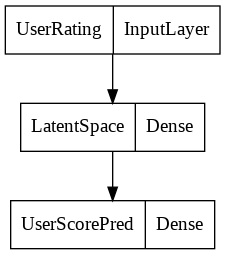

In [ ]:
plot_model(AutoRec, to_file='AutoRec.png')

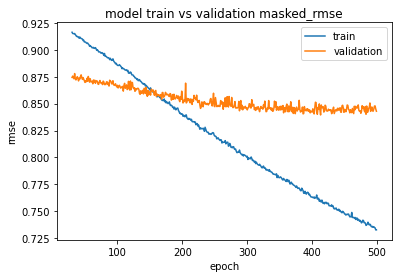

In [ ]:
show_rmse(hist_Autorec, 30)

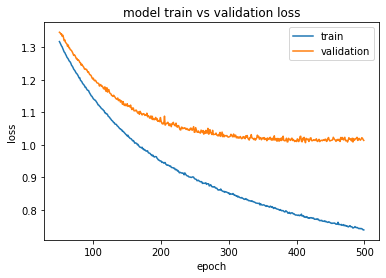

In [ ]:
show_error(hist_Autorec, 50)

In [ ]:
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0299 - masked_rmse_clip: 0.8615


In [ ]:
predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

In [ ]:
predict_autorec

array([[ 3.3899035 ,  1.0588211 ,  0.09526086, ...,  0.11352107,
        -0.01244743,  0.59717906],
       [ 0.22444199,  0.820651  ,  0.45722738, ...,  0.12308255,
         0.08384033,  0.6910616 ],
       [ 0.59742785,  0.1648664 ,  0.08036773, ...,  0.10541866,
         0.02608023,  0.21365827],
       ...,
       [ 0.5191186 ,  0.19468774,  0.20272793, ...,  0.0245548 ,
         0.06609137,  0.24436851],
       [ 0.8481528 , -0.1227652 , -0.5372296 , ...,  0.24417847,
         0.298652  ,  0.2780261 ],
       [ 1.177402  , -0.3906144 , -0.75558954, ...,  0.6844319 ,
         0.673982  ,  0.29808748]], dtype=float32)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)

2.4904206

In [ ]:
# model_json = AutoRec.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# AutoRec.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk


In [ ]:
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Loaded model from disk


In [ ]:
# from tensorflow.python.keras.optimizer_v2.adam import Adam
# optimizer = Adam(learning_rate = 0.001)
# loaded_model.compile(optimizer = optimizer, loss=masked_se, metrics=[masked_rmse_clip])
# score = loaded_model.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))
# score


189/189 [==============================] - 1s 2ms/step - loss: 130.9640 - masked_rmse_clip: 2.6245


[130.96400451660156, 2.624509572982788]

## Deep AE CF

In [ ]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [ ]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001)
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = optimizer, loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-tra

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.4044 - masked_rmse_clip: 2.8650 - val_loss: 14.1322 - val_masked_rmse_clip: 2.7533 - 1s/epoch - 54ms/step
Epoch 2/500
24/24 - 0s - loss: 11.5391 - masked_rmse_clip: 2.5406 - val_loss: 6.8618 - val_masked_rmse_clip: 1.9460 - 332ms/epoch - 14ms/step
Epoch 3/500
24/24 - 0s - loss: 6.4289 - masked_rmse_clip: 1.8541 - val_loss: 4.0009 - val_masked_rmse_clip: 1.3914 - 315ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 4.3852 - masked_rmse_clip: 1.5202 - val_loss: 3.0883 - val_masked_rmse_clip: 1.1281 - 310ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 3.7460 - masked_rmse_clip: 1.3743 - val_loss: 2.8276 - val_masked_rmse_clip: 1.0503 - 302ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 3.4906 - masked_rmse_clip: 1.3160 - val_loss: 2.7013 - val_masked_rmse_clip: 1.0138 - 312ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 3.3510 - masked_rmse_clip: 1.2848 - val_loss: 2.6155 - val_masked_rmse_clip: 0.9895 - 316ms/epoch - 13ms/step
Epoch 8/500
2

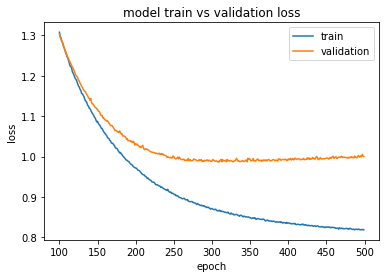

In [ ]:
show_error(hist_Deep_AE, 100)

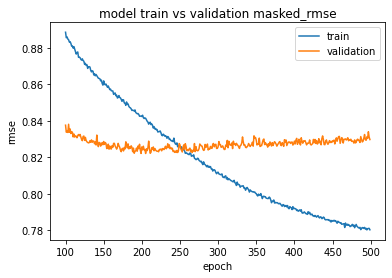

In [ ]:
show_rmse(hist_Deep_AE, 100)

In [ ]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [ ]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9981 - masked_rmse_clip: 0.8409


In [ ]:
predict_deep

array([[4.323808 , 3.7828426, 3.3257117, ..., 3.3987288, 3.1870956,
        4.110668 ],
       [3.768477 , 3.2259476, 3.3255057, ..., 2.9617858, 3.2655628,
        3.6546762],
       [3.4466016, 2.9918525, 3.5590687, ..., 2.167493 , 3.050041 ,
        3.9097607],
       ...,
       [3.3907142, 3.043375 , 3.141811 , ..., 2.7128816, 2.8015509,
        3.9676178],
       [4.0154924, 3.0268676, 2.5538478, ..., 3.5525484, 3.49033  ,
        3.933291 ],
       [3.6318986, 2.2896898, 1.5800782, ..., 3.5059903, 4.0410438,
        3.3933203]], dtype=float32)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.759522

In [ ]:
for layer in Deep_AE.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrain

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]

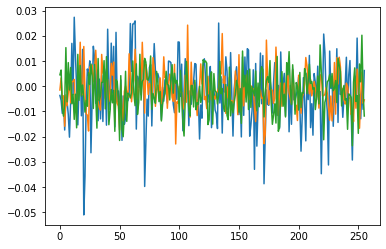

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

In [ ]:
movies = pd.read_csv('ml1m_movies.csv',sep=',', encoding='latin-1', 
                      usecols=['movie_emb_id', 'title', 'genre'])

In [ ]:
def Deep_AE_recommend_topx(userid, system, movies, number):
    temp = system.loc[userid,:]
    query = temp.sort_values(ascending=False)
    moviesids = query[0:number].index
    
    return (movies[movies.movie_emb_id.isin(moviesids.astype(int).tolist())])

# Recommend 20 movies to user 2000

In [ ]:
my_predict=pd.DataFrame(predict_deep)
Deep_AE_recommend_topx(2000,my_predict,movies,20)

,movie_emb_id,title,genre
589,592,"Silence of the Lambs, The (1991)",Drama|Thriller
1061,1076,Sleeper (1973),Comedy|Sci-Fi
1083,1098,"Christmas Carol, A (1938)",Drama
1191,1208,Once Upon a Time in the West (1969),Western
1201,1218,Psycho (1960),Horror|Thriller
1722,1779,Ayn Rand: A Sense of Life (1997),Documentary
1831,1899,"Children of Heaven, The (Bacheha-Ye Aseman) (1...",Drama
2128,2196,Firelight (1997),Drama
2481,2549,"Haunting, The (1963)",Horror|Thriller
2555,2623,After Life (1998),Drama


## Add Denoise

### Gaussian Noise

#### Gussian AutoRec

In [ ]:
## Adding Gaussin noise to input
noise_factor = 0.4
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 

In [ ]:
users_items_matrix_train_average_noisy

array([[4.41823855, 4.16948445, 3.78476121, ..., 4.48321826, 4.41950555,
        4.25920452],
       [3.29302037, 3.23572109, 3.17309438, ..., 3.77351399, 3.92938923,
        3.77276856],
       [4.87915445, 3.86185954, 3.91195884, ..., 3.80952432, 3.70279243,
        4.60548906],
       ...,
       [3.80216538, 3.70608186, 5.03700092, ..., 3.04010565, 4.20286867,
        3.79395522],
       [3.69530637, 3.54849294, 3.51037896, ..., 3.86419232, 3.28789285,
        4.36132094],
       [2.80994553, 3.8443523 , 2.89136119, ..., 3.71788668, 3.25591573,
        3.65384625]])

In [ ]:

AutoRec = AutoRec(users_items_matrix_train_average_noisy, 0.001 , 'elu' , 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average_noisy, users_items_matrix_validate.astype(float)])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
24/24 - 1s - loss: 7.9499 - masked_rmse_clip: 1.8391 - val_loss: 4.2511 - val_masked_rmse_clip: 1.2459 - 1s/epoch - 43ms/step
Epoch 2/500
24/24 - 0s - loss: 3.4015 - masked_rmse_clip: 1.1569 - val_loss: 2.8151 - val_masked_rmse_clip: 0.9573 - 324ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 2.6

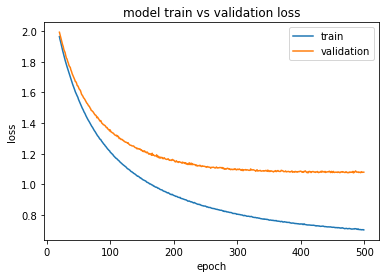

In [ ]:
show_error(hist_Autorec, 20)

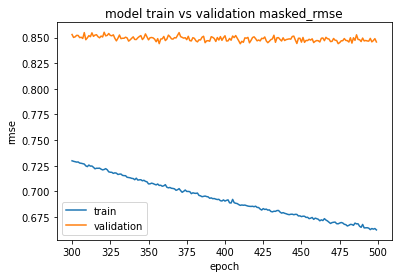

In [ ]:
show_rmse(hist_Autorec, 300)

In [ ]:
test_result_deep = AutoRec.evaluate(users_items_matrix_train_average_noisy.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0925 - masked_rmse_clip: 0.8630


#### Gaussian Deep AE CF

In [ ]:
layers = [256, 512, 256]
dropout = 0.8

activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-tra

In [ ]:
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero_noisy.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.5505 - masked_rmse_clip: 2.8588 - val_loss: 14.7154 - val_masked_rmse_clip: 2.7659 - 1s/epoch - 49ms/step
Epoch 2/500
24/24 - 0s - loss: 12.2234 - masked_rmse_clip: 2.5792 - val_loss: 7.7976 - val_masked_rmse_clip: 2.0848 - 311ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 7.3465 - masked_rmse_clip: 1.9708 - val_loss: 4.7725 - val_masked_rmse_clip: 1.5598 - 315ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 5.0336 - masked_rmse_clip: 1.6309 - val_loss: 3.5062 - val_masked_rmse_clip: 1.2348 - 325ms/epoch - 14ms/step
Epoch 5/500
24/24 - 0s - loss: 4.1707 - masked_rmse_clip: 1.4587 - val_loss: 3.0909 - val_masked_rmse_clip: 1.1178 - 299ms/epoch - 12ms/step
Epoch 6/500
24/24 - 0s - loss: 3.8428 - masked_rmse_clip: 1.3825 - val_loss: 2.9172 - val_masked_rmse_clip: 1.0665 - 313ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 3.6576 - masked_rmse_clip: 1.3442 - val_loss: 2.7988 - val_masked_rmse_clip: 1.0305 - 299ms/epoch - 12ms/step
Epoch 8/500
2

In [ ]:
#plot_model(Deep_AE_user, to_file='model.png')

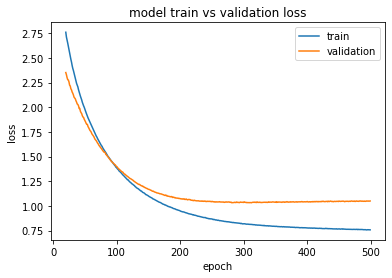

In [ ]:
show_error(hist_Deep_AE_denoise, 20)

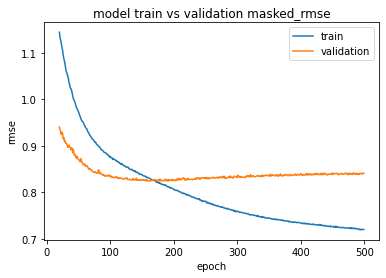

In [ ]:
show_rmse(hist_Deep_AE_denoise, 20)

In [ ]:
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0544 - masked_rmse_clip: 0.8553


In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.74953765

In [ ]:
predict_deepAE_denoise = Deep_AE_denoise.predict(users_items_matrix_train_zero_noisy)

In [ ]:
my_predict_deepAE=pd.DataFrame(predict_deepAE_denoise)
Deep_AE_recommend_topx(2000,my_predict_deepAE,movies,20)

,movie_emb_id,title,genre
33,33,Babe (1995),Children's|Comedy|Drama
896,907,North by Northwest (1959),Drama|Thriller
907,918,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
911,922,Citizen Kane (1941),Drama
1061,1076,Sleeper (1973),Comedy|Sci-Fi
1163,1178,"Grifters, The (1990)",Crime|Drama|Film-Noir
1172,1188,"Thin Blue Line, The (1988)",Documentary
1194,1211,"Third Man, The (1949)",Mystery|Thriller
1201,1218,Psycho (1960),Horror|Thriller
1280,1299,My Life as a Dog (Mitt liv som hund) (1985),Drama


### Dropout Noise

In [ ]:
def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 dropout_2 (Dropout)         (None, 3952)              0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015

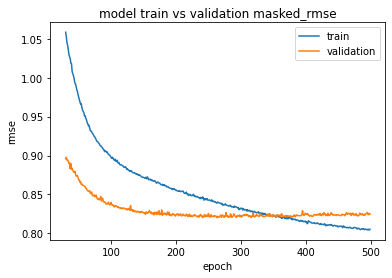

In [ ]:
show_rmse(hist_Deep_AE_denoise_dropN, 30)

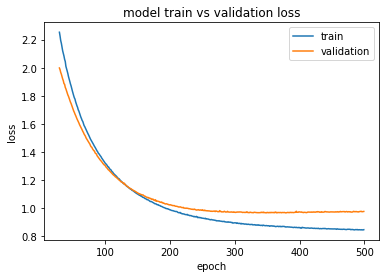

In [ ]:
show_error(hist_Deep_AE_denoise_dropN, 30)

In [ ]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero.astype(float), users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9679 - masked_rmse_clip: 0.8340


In [ ]:
predict_deepAE_denoise_dropN = Deep_AE_denoise_dropN.predict(users_items_matrix_train_zero_noisy)

In [ ]:
my_predict_deepAE_dropN=pd.DataFrame(predict_deepAE_denoise_dropN)
Deep_AE_recommend_topx(2000,my_predict_deepAE_dropN,movies,20)

,movie_emb_id,title,genre
589,592,"Silence of the Lambs, The (1991)",Drama|Thriller
604,607,Fargo (1996),Crime|Drama|Thriller
740,749,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
855,865,Bound (1996),Crime|Drama|Romance|Thriller
1061,1076,Sleeper (1973),Comedy|Sci-Fi
1131,1146,When We Were Kings (1996),Documentary
1191,1208,Once Upon a Time in the West (1969),Western
1194,1211,"Third Man, The (1949)",Mystery|Thriller
1196,1213,Alien (1979),Action|Horror|Sci-Fi|Thriller
1201,1218,Psycho (1960),Horror|Thriller
